In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

from models.no_code_model import estimate_prediction_by_elo
from config import PROCESSED_FOLDER_PATH

In [3]:
data_path = os.path.join(PROCESSED_FOLDER_PATH, "lichess_db_standard_rated_2017-03.csv")
df = pd.read_csv(data_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122226 entries, 0 to 122225
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Event              122226 non-null  object 
 1   WhiteElo           122226 non-null  int64  
 2   BlackElo           122226 non-null  int64  
 3   TimeControl        122226 non-null  object 
 4   Result             122226 non-null  object 
 5   MeanElo            122226 non-null  float64
 6   EloDiff            122226 non-null  int64  
 7   EloDiffAbs         122226 non-null  int64  
 8   BaseTime           122226 non-null  int64  
 9   IncrementTime      122226 non-null  int64  
 10  ZeroIncrementTime  122226 non-null  int64  
 11  ResultEncoded      122226 non-null  int64  
 12  WhiteWin           122226 non-null  int64  
 13  BlackWin           122226 non-null  int64  
 14  Draw               122226 non-null  int64  
 15  DrawEventProb      122226 non-null  float64
 16  Wh

In [5]:
df.head()

,Event,WhiteElo,BlackElo,TimeControl,Result,MeanElo,EloDiff,EloDiffAbs,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw,DrawEventProb,WhiteWinEventProb,BlackWinEventProb
0,Rated Blitz game,1234,1467,300+0,0-1,1350.5,-233,233,300,0,1,1,0,1,0,0.023024,0.502173,0.474803
1,Rated Blitz game,1988,1960,180+0,1-0,1974.0,28,28,180,0,1,0,1,0,0,0.023024,0.502173,0.474803
2,Rated Blitz game,1891,1900,300+0,1-0,1895.5,-9,9,300,0,1,0,1,0,0,0.023024,0.502173,0.474803
3,Rated Classical game,1342,1364,600+0,1-0,1353.0,-22,22,600,0,1,0,1,0,0,0.037033,0.481990,0.480977
4,Rated Classical game,1575,1630,900+15,0-1,1602.5,-55,55,900,15,0,1,0,1,0,0.037033,0.481990,0.480977


In [6]:
df = pd.get_dummies(df, columns=["Event"], dtype=np.int8, prefix="", prefix_sep="")

In [7]:
df.drop(columns=["TimeControl", "Result"], inplace=True)

In [8]:
df.head()

,WhiteElo,BlackElo,MeanElo,EloDiff,EloDiffAbs,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,...,Draw,DrawEventProb,WhiteWinEventProb,BlackWinEventProb,Rated Blitz game,Rated Blitz tournament,Rated Bullet game,Rated Bullet tournament,Rated Classical game,Rated Classical tournament
0,1234,1467,1350.5,-233,233,300,0,1,1,0,...,0,0.023024,0.502173,0.474803,1,0,0,0,0,0
1,1988,1960,1974.0,28,28,180,0,1,0,1,...,0,0.023024,0.502173,0.474803,1,0,0,0,0,0
2,1891,1900,1895.5,-9,9,300,0,1,0,1,...,0,0.023024,0.502173,0.474803,1,0,0,0,0,0
3,1342,1364,1353.0,-22,22,600,0,1,0,1,...,0,0.037033,0.481990,0.480977,0,0,0,0,1,0
4,1575,1630,1602.5,-55,55,900,15,0,1,0,...,0,0.037033,0.481990,0.480977,0,0,0,0,1,0


In [9]:
def process_data(data: pd.DataFrame, count_draws: bool = False):
    if not count_draws:
        data = data[data["Draw"] != 1]
    
    x_data = data.drop(columns=["ResultEncoded", "WhiteWin", "BlackWin", "Draw"])
    y_data = data["ResultEncoded"]
    
    columns_to_scale = [
        "WhiteElo", "BlackElo", "MeanElo", "EloDiff", "EloDiffAbs", "BaseTime", 
        "IncrementTime", "DrawEventProb", "WhiteWinEventProb", "BlackWinEventProb",
    ]
    
    scaler = StandardScaler()
    x_data[columns_to_scale] = scaler.fit_transform(x_data[columns_to_scale])
    
    unique_y = y_data.unique()
    class_weights = compute_class_weight("balanced", classes=unique_y, y=y_data)
    class_weights = dict(zip(unique_y, class_weights))
    
    return x_data, y_data, class_weights

def estimate_model(true, predict, model, features):
    report = classification_report(true, predict)
    print("Classification Report:")
    print(report)
    
    conf_matrix = confusion_matrix(true, predict)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    importance = np.abs(model.coef_[0])
    importance_df = pd.DataFrame({"Feature": features, "Importance": importance})
    
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

In [10]:
def main(predict_draws, data, penalty="l1", solver="saga"):
    print("Count draws:", predict_draws)
    
    accuracy = estimate_prediction_by_elo(data, count_draws=predict_draws)
    print("\nNaive prediction (player with the highest rating wins)")
    print("\tAccuracy:", accuracy)
    
    print("\nLogistic Regression Model")
    X, y, weights = process_data(data, count_draws=predict_draws)
    print("Class weights:", "".join(map(lambda x: f"\n\t{int(x[0])}: {float(x[1])}", weights.items())))
    print(f"Penalty: {penalty}\n")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    clf = LogisticRegression(class_weight=weights, random_state=42, max_iter=600, penalty=penalty, solver=solver)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    estimate_model(y_test, y_pred, clf, X.columns)

Count draws: False

Naive prediction (player with the highest rating wins)
	Accuracy: 0.6021736574221834

Logistic Regression Model
Class weights: 
	1: 1.018355058332478
	0: 0.9822948980265329
Penalty: l1

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      5919
           1       0.61      0.59      0.60      5988

    accuracy                           0.60     11907
   macro avg       0.60      0.60      0.60     11907
weighted avg       0.60      0.60      0.60     11907



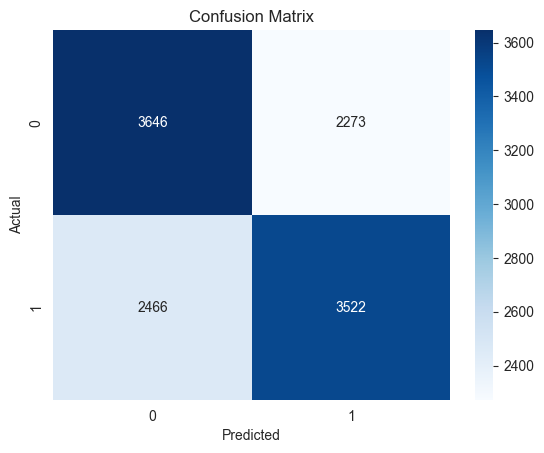

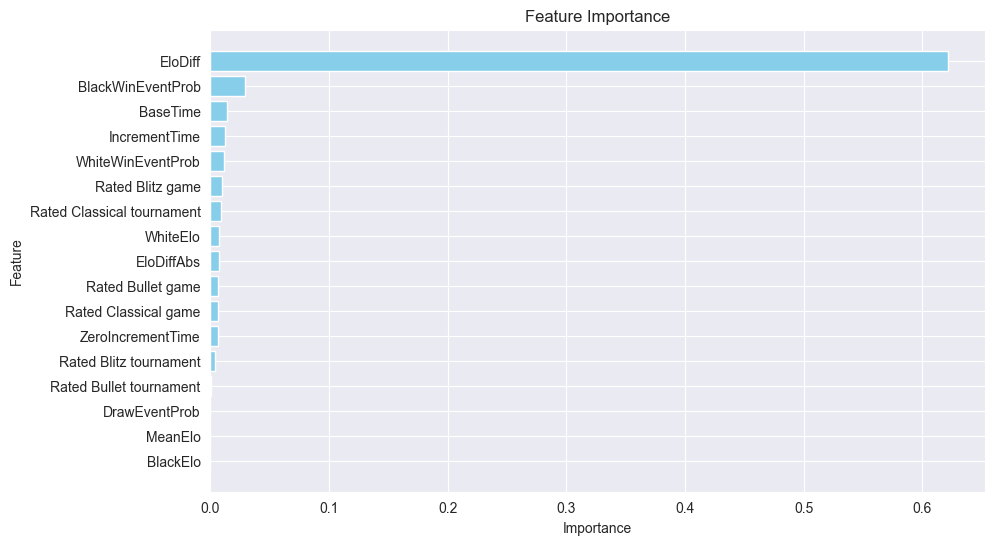

In [11]:
main(predict_draws=False, data=df, penalty="l1")

Count draws: True

Naive prediction (player with the highest rating wins)
	Accuracy: 0.5865855055389197

Logistic Regression Model
Class weights: 
	1: 0.6969448150809128
	0: 0.6722658570391393
	2: 12.876738305941846
Penalty: l1

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.39      0.48      6074
           1       0.60      0.43      0.50      5849
           2       0.04      0.53      0.07       300

    accuracy                           0.41     12223
   macro avg       0.42      0.45      0.35     12223
weighted avg       0.59      0.41      0.48     12223



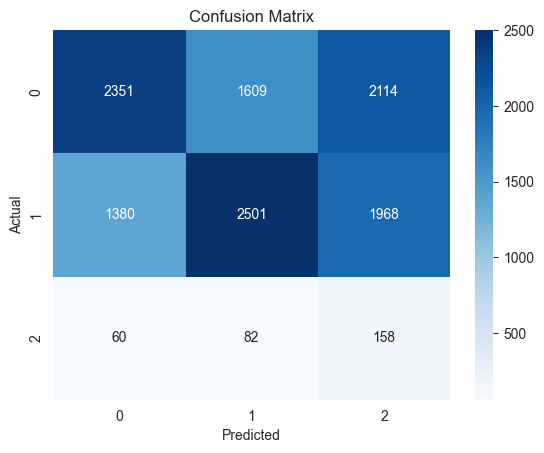

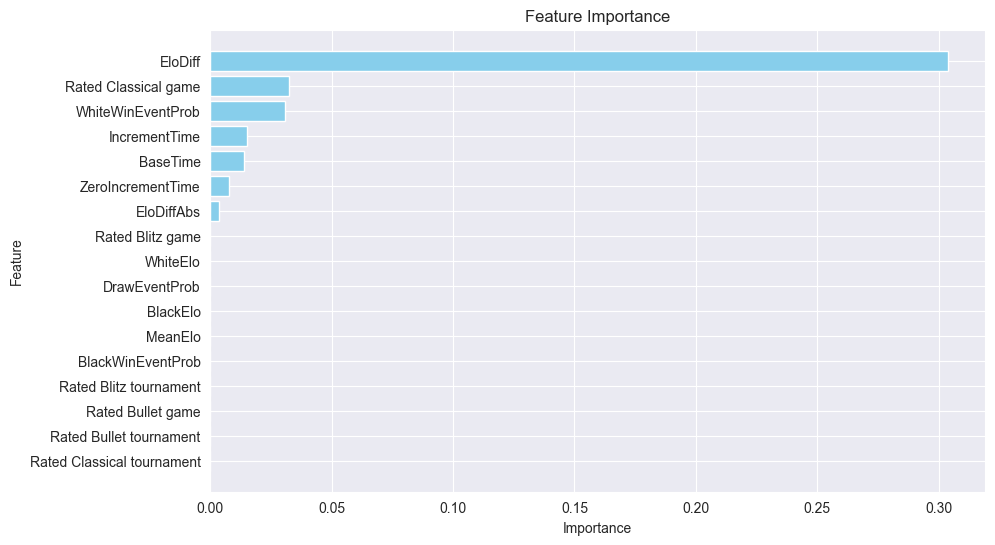

In [12]:
main(predict_draws=True, data=df, penalty="l1")

Count draws: False

Naive prediction (player with the highest rating wins)
	Accuracy: 0.6021736574221834

Logistic Regression Model
Class weights: 
	1: 1.018355058332478
	0: 0.9822948980265329
Penalty: l2

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      5919
           1       0.61      0.59      0.60      5988

    accuracy                           0.60     11907
   macro avg       0.60      0.60      0.60     11907
weighted avg       0.60      0.60      0.60     11907



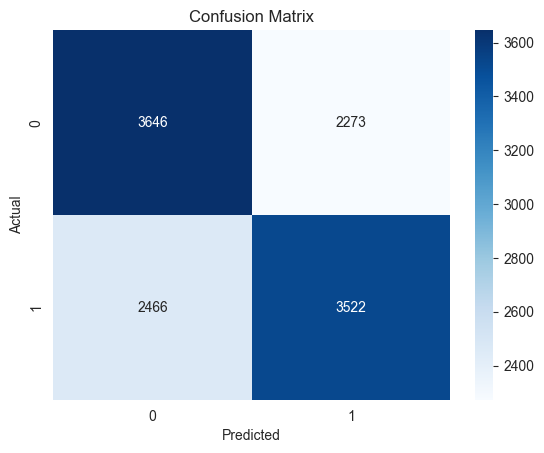

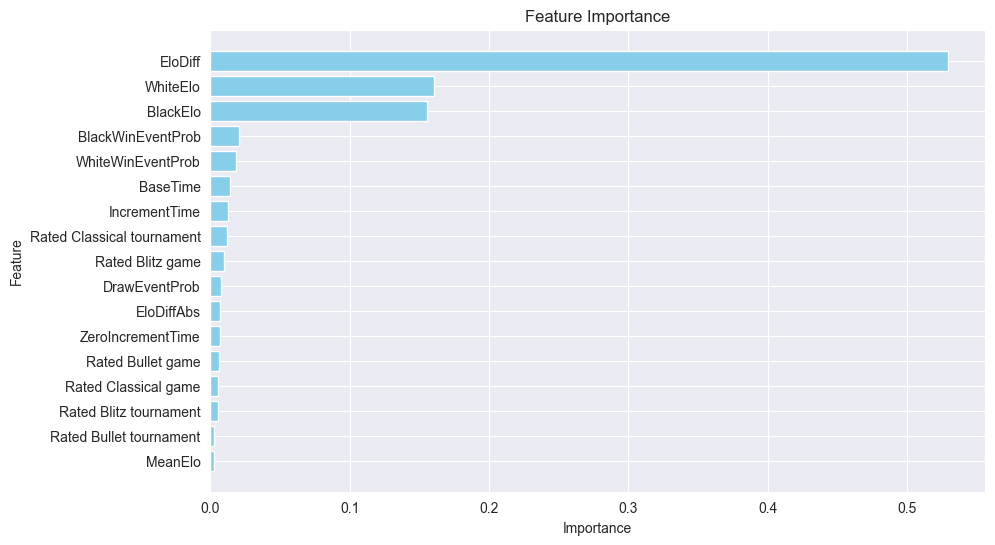

In [13]:
main(predict_draws=False, data=df, penalty="l2")

Count draws: True

Naive prediction (player with the highest rating wins)
	Accuracy: 0.5865855055389197

Logistic Regression Model
Class weights: 
	1: 0.6969448150809128
	0: 0.6722658570391393
	2: 12.876738305941846
Penalty: l2

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.39      0.48      6074
           1       0.60      0.43      0.50      5849
           2       0.04      0.53      0.07       300

    accuracy                           0.41     12223
   macro avg       0.42      0.45      0.35     12223
weighted avg       0.59      0.41      0.48     12223



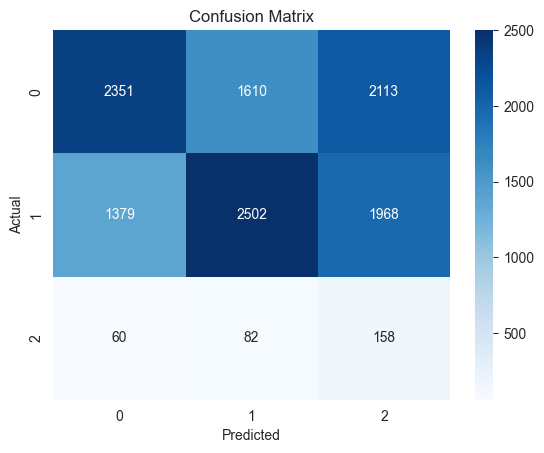

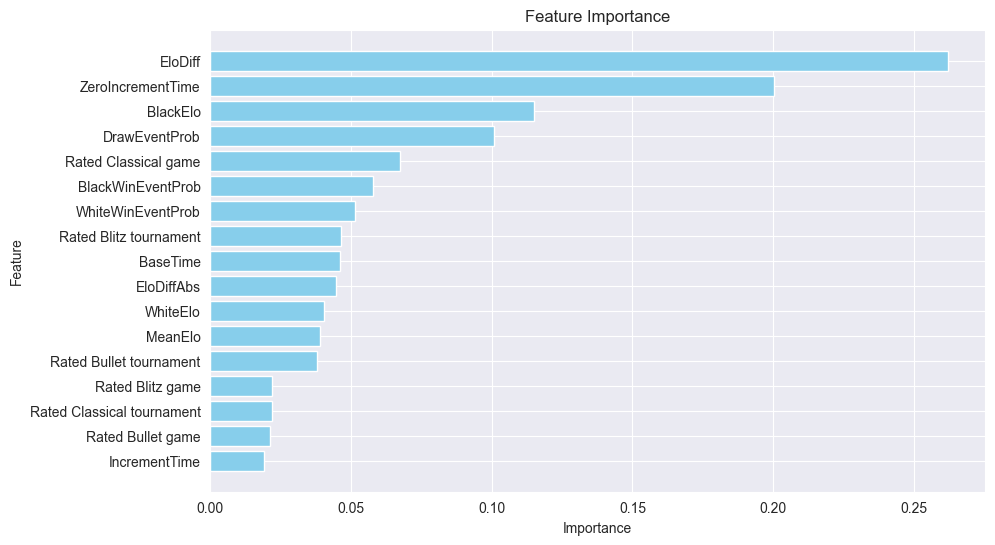

In [14]:
main(predict_draws=True, data=df, penalty="l2")